In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [5]:
from math import log10 , floor
def round_it(x, sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [6]:
def calc_unc(values):
    return (max(values) - min(values)) / 2

In [7]:
diesel_df = pd.read_csv('diesel_data.csv')
petrol_df = pd.read_csv('petrol_data.csv')

In [8]:
# pd.set_option('display.max_rows', None)

In [9]:
for df in [diesel_df, petrol_df]:
    df.loc[df['Fuel Flow Rate (cm^3/min)'] < 15, 'Fuel Flow Rate (cm^3/min)'] = 15
    

In [10]:
diesel_df

,Barometric Pressure (mBar),Inlet Pressure (kPa),Air Flow Pressure (Pa),Oil Pressure (Bar),Fuel Pressure (Bar),Throttle Position (%),Torque (Nm),Engine Speed (rpm),Fuel Flow Rate (cm^3/min),Air Temp. (C),...,Exhaust Temp. (C),Plant In Temp. (C),Cool In Temp. (C),Cool Out Temp. (C),Dyno Out Temp. (C),Oil In Temp. (C),Cal Water In Temp. (C),Cal Water Out Temp. (C),Cal Exhaust In Temp. (C),Cal Exhaust Out Temp. (C)
0,1021.63,99.84,259.17,4.64,2.27,15.55,20.79,1215.94,15.0,22.64,...,147.07,16.89,39.23,38.32,17.35,38.16,17.51,20.34,60.46,19.87
1,1022.28,99.09,196.53,4.62,2.35,16.00,20.76,1216.28,15.0,22.64,...,147.09,16.85,39.30,38.40,17.20,38.17,17.55,20.24,60.57,19.89
2,1023.19,99.80,385.81,4.63,2.31,16.38,20.98,1217.39,15.0,22.56,...,147.01,16.82,39.41,38.51,17.06,38.29,17.60,20.20,60.86,19.93
3,1023.16,101.46,150.29,4.61,2.33,16.95,21.08,1219.72,15.0,22.64,...,146.95,16.85,39.54,38.60,16.95,38.39,17.58,20.23,61.13,20.06
4,1022.92,100.30,221.12,4.59,2.25,17.21,20.44,1214.58,15.0,22.61,...,146.92,16.93,39.62,38.70,17.00,38.49,17.47,20.23,61.36,20.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,1018.58,100.76,296.08,2.33,2.46,19.05,30.57,1297.94,15.0,25.36,...,194.77,16.96,72.96,70.94,17.83,78.27,18.07,25.34,194.46,22.86
83,1018.52,100.72,334.15,2.33,2.62,19.43,30.75,1297.17,15.0,25.45,...,194.75,17.05,72.93,70.83,17.58,77.96,18.08,25.02,194.34,22.92
84,1019.09,98.39,290.83,2.33,2.34,19.85,30.68,1296.43,15.0,25.38,...,194.68,17.05,72.90,70.62,17.52,77.98,18.07,25.03,194.35,22.98
85,1019.27,101.54,306.04,2.33,2.62,20.17,30.71,1297.22,15.0,25.37,...,194.62,17.04,72.95,70.46,17.46,78.03,18.13,24.99,194.35,23.02


In [11]:
diesel = {'fuel': 'diesel', 'Vd': 1.9, 'rv': 22, 'CV': 42500, 'rho': 840, 'clfm': 55.9 * 10 ** (-6)}
petrol = {'fuel': 'petrol', 'Vd': 1.198, 'rv': 10.3, 'CV': 44000, 'rho': 770, 'clfm': 50.199 * 10 ** (-6)}

arho = 1.2

gamma = 1.4

In [12]:
def remove_columns(df):
    return df[[ 'Air Flow Pressure (Pa)', 'Torque (Nm)', 'Engine Speed (rpm)', 'Fuel Flow Rate (cm^3/min)', 'Exhaust Temp. (C)', 'Plant In Temp. (C)']]

In [13]:
diesel_df = remove_columns(diesel_df)
petrol_df = remove_columns(petrol_df)

In [14]:
def addCalculatedColumns(df, dict):
    df['Brake Power [kW]'] = df['Torque (Nm)'] * df['Engine Speed (rpm)'] * 2 * np.pi / 60 * 10 ** (-3)
    df['BMEP [kPa]'] = df['Torque (Nm)'] * 4 * np.pi / dict['Vd']
    df['Air Mass Flow Rate [kg/s]'] = dict['clfm']  * arho * df['Air Flow Pressure (Pa)']
    df['Fuel Mass Flow Rate [kg/s]'] = df['Fuel Flow Rate (cm^3/min)'] * 60 / 10 ** 6 * dict['rho']
    df['Cut-off Ratio'] = ((df['Exhaust Temp. (C)'] + 273) / (df['Plant In Temp. (C)'] + 273)) ** (1 / gamma)
    df['Air to Fuel Ratio'] = df['Air Mass Flow Rate [kg/s]'] / df['Fuel Mass Flow Rate [kg/s]']
    df['Brake Thermal Efficiency'] = (df['Brake Power [kW]'] * 10 ** 3)/ (df['Fuel Mass Flow Rate [kg/s]'] * dict['CV'])
    df['Volumetric Efficiency'] = (df['Fuel Mass Flow Rate [kg/s]'] * 10 ** 3) / (dict['Vd'] * arho)
    df['Brake Specific Fuel Consumption'] = df['Fuel Mass Flow Rate [kg/s]'] / df['Brake Power [kW]'] * 60 * 10 ** (-3)

    if dict['fuel'] == 'petrol':
        df['Thermal Efficiency'] = 1 - 1 / (dict['rv'] ** (gamma - 1))

    if dict['fuel'] == 'diesel':
        df['Thermal Efficiency'] = 1 - 1 / gamma * 1 / (dict['rv'] ** (gamma - 1)) * (df['Cut-off Ratio'] ** gamma - 1) / (df['Cut-off Ratio'] - 1)
    
    return df

In [15]:
diesel_df = addCalculatedColumns(diesel_df, diesel)
petrol_df = addCalculatedColumns(petrol_df, petrol)

C:\Users\Charlie\AppData\Local\Temp\ipykernel_2352\802695132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Brake Power [kW]'] = df['Torque (Nm)'] * df['Engine Speed (rpm)'] * 2 * np.pi / 60 * 10 ** (-3)
C:\Users\Charlie\AppData\Local\Temp\ipykernel_2352\802695132.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BMEP [kPa]'] = df['Torque (Nm)'] * 4 * np.pi / dict['Vd']
C:\Users\Charlie\AppData\Local\Temp\ipykernel_2352\802695132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a

In [16]:
def scatter(axs, df, x, y, row, col):
    r = np.corrcoef(df[x], df[y])[0,1]
    axs[row, col].scatter(df[x], df[y])
    axs[row,col].set(xlabel=x, ylabel=y)
    axs[row, col].text(0.5, 0.9, f'Corr. coeff., r = {np.round(r, 2)}', horizontalalignment='center', verticalalignment='center', transform=axs[row, col].transAxes)

In [17]:
labels = ['Brake Power [kW]', 'Air Mass Flow Rate [kg/s]',
       'Fuel Mass Flow Rate [kg/s]', 'Air to Fuel Ratio',
       'Brake Thermal Efficiency', 'Volumetric Efficiency',
       'Brake Specific Fuel Consumption', 'Cut-off Ratio', 'Thermal Efficiency']

In [18]:
def plot(df):
    row = 0
    col = 0
    f, axs = plt.subplots(3,3,figsize=(12,8))
    f.tight_layout(pad=3)
    for label_index in range(len(labels)):
        scatter(axs, df, 'Engine Speed (rpm)', labels[label_index], row, col)
        if (label_index+1) % 3 == 0:
                col = 0
                row += 1
        else:
                col += 1
    plt.show()

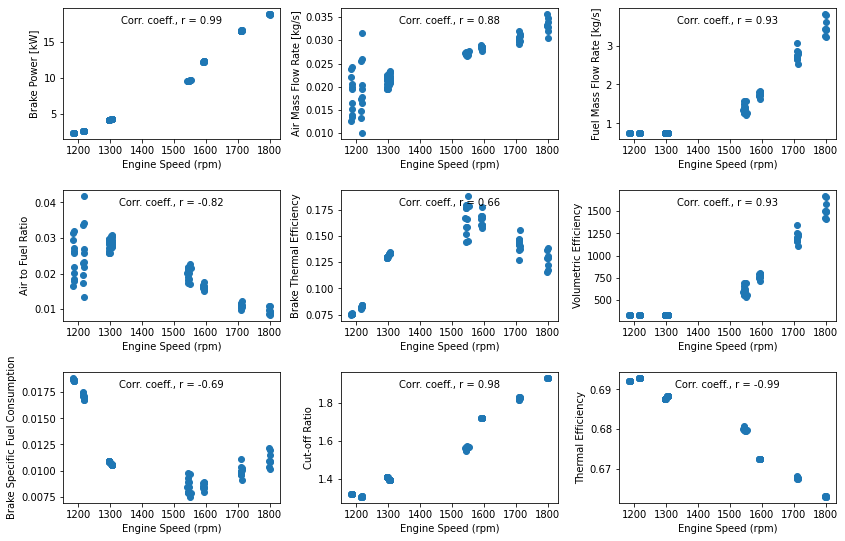

In [19]:
plot(diesel_df)

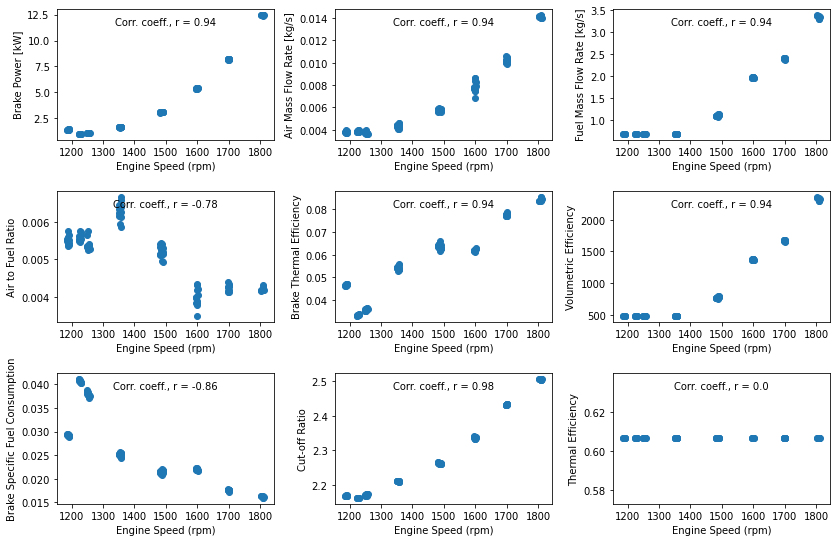

In [20]:
plot(petrol_df)

In [21]:
speed_operating_point_ranges = [(1150, 1280), (1280, 1400), (1450, 1580), (1580, 1620), (1680, 1730), (1780, 1820)]

In [22]:
def mask(range, df):
    return (df['Engine Speed (rpm)'] > range[0]) & (df['Engine Speed (rpm)'] < range[1])

In [23]:
def get_df_from_list_of_series(list):
    dict = {label: [] for label in list[0].index}

    for series in list:
        for label in series.index:
            dict[label].append(series[label])

    return pd.DataFrame.from_dict(dict)

In [24]:
def get_average_and_range_dfs_as_dict(df):

    averages = []
    descriptions = []

    for range_value in speed_operating_point_ranges:
        averages.append(df[mask(range_value, df)].mean())
        descriptions.append(df[mask(range_value, df)].describe())

    ranges = []

    for description in descriptions:
        description = description.transpose()
        description['range'] = description['std'] * 3
        ranges.append(description['range'])

    return {'average': get_df_from_list_of_series(averages), 'range': get_df_from_list_of_series(ranges)}


In [25]:
petrol_dict = get_average_and_range_dfs_as_dict(petrol_df)
diesel_dict = get_average_and_range_dfs_as_dict(diesel_df)

In [26]:
petrol_dict['range']

,Air Flow Pressure (Pa),Torque (Nm),Engine Speed (rpm),Fuel Flow Rate (cm^3/min),Exhaust Temp. (C),Plant In Temp. (C),Brake Power [kW],BMEP [kPa],Air Mass Flow Rate [kg/s],Fuel Mass Flow Rate [kg/s],Cut-off Ratio,Air to Fuel Ratio,Brake Thermal Efficiency,Volumetric Efficiency,Brake Specific Fuel Consumption,Thermal Efficiency
0,5.100488,4.786110,82.149188,0.000000,6.554172,0.258504,0.536122,50.203701,0.000307,1.015718e-15,0.010679,0.000443,0.017582,3.466983e-13,0.014979,3.385725e-16
1,7.640485,0.488365,9.020060,0.000000,1.234601,0.183957,0.068443,5.122680,0.000460,3.447570e-16,0.001851,0.000664,0.002245,7.060623e-13,0.001035,3.447570e-16
2,5.376697,0.395543,10.461609,1.160891,3.091523,0.116998,0.078612,4.149032,0.000324,5.363318e-02,0.005527,0.000459,0.002999,3.730744e+01,0.001007,3.447570e-16
3,25.135326,0.449333,5.087173,0.934680,4.872056,0.084329,0.082675,4.713258,0.001514,4.318223e-02,0.008565,0.000752,0.001300,3.003772e+01,0.000461,3.478770e-16
4,11.943277,0.356322,4.235111,1.121462,2.043670,0.091800,0.068888,3.737626,0.000719,5.181153e-02,0.003603,0.000273,0.001725,3.604030e+01,0.000388,3.493235e-16
5,4.479599,0.487308,7.713670,1.853478,2.145806,0.078335,0.073110,5.111597,0.000270,8.563070e-02,0.003871,0.000134,0.001979,5.956504e+01,0.000379,3.493235e-16


In [27]:
quantity_error_dict = {'Brake Power [kW]': ['Torque (Nm)', 'Engine Speed (rpm)'], 'Brake Thermal Efficiency': ['Torque (Nm)', 'Engine Speed (rpm)', 'Fuel Flow Rate (cm^3/min)'], 'Brake Specific Fuel Consumption': ['Torque (Nm)', 'Engine Speed (rpm)', 'Fuel Flow Rate (cm^3/min)'], 'BMEP [kPa]': ['Torque (Nm)'], 'Volumetric Efficiency': ['Engine Speed (rpm)', 'Air Flow Pressure (Pa)'], 'Air to Fuel Ratio': ['Air Flow Pressure (Pa)', 'Fuel Flow Rate (cm^3/min)'], 'Cut-off Ratio': ['Plant In Temp. (C)', 'Exhaust Temp. (C)'], 'Thermal Efficiency': ['Cut-off Ratio']}

In [28]:
def get_y_error_list(x, y, fuel_df_dict, quantity_of_interest):
    df_average = fuel_df_dict['average'] 
    df_range = fuel_df_dict['range']

    y_error_list = [0 for i in range(len(x))]

    for quantity in quantity_error_dict[quantity_of_interest]:
        for i in range(len(x)):
            y_error_list[i] += df_range[quantity][i] / df_average[quantity][i]
    if quantity_of_interest == 'Cut-off Ratio':
        return [y_error_list[i] * y[i] * 1 / gamma for i in range(len(y))]
    if quantity_of_interest == 'Thermal Efficiency':
        return [y_error_list[i] * y[i] * gamma for i in range(len(y))]
    else:
        return [y_error_list[i] * y[i] for i in range(len(y))]

In [40]:
def get_fuel_axis(fuel_dict, quantity_of_interest):
    df_average = fuel_dict['average']
    x_fuel = df_average['Engine Speed (rpm)'].tolist()
    y_fuel = df_average[quantity_of_interest].tolist()
    y_err = get_y_error_list(x_fuel, y_fuel, fuel_dict, quantity_of_interest)
    correlation_coefficient = np.round(np.corrcoef(x_fuel, y_fuel)[0,1],2)

    return x_fuel, y_fuel, y_err, correlation_coefficient

In [30]:
def set_all_axis_labels(axs, xlabel):
    for ax in axs:
        ax.set_xlabel(xlabel, fontsize = 16)
        ax.grid()
        ax.legend(loc='best', fontsize=12)

In [55]:
def plot_polynomial(axs, x_values, y_values, order, number_of_points):
        polynomial_function_order_3 = np.poly1d(np.polyfit(x_values, y_values, order))
        coefficients = polynomial_function_order_3.c

        rounded_coefficients = [round_it(coefficient, 1) for coefficient in coefficients]
        coefficient_signs = []
        for coefficient in rounded_coefficients:
                if coefficient > 0:
                        coefficient_signs.append('+')
                else:
                        coefficient_signs.append('')
        x_polynomial = np.linspace(x_values[0], x_values[-1], number_of_points)
        y_polynomial = polynomial_function_order_3(x_polynomial)
        axs.plot(x_polynomial, y_polynomial, color='red', linestyle='dashed', label=f'Trendline: y = {rounded_coefficients[0]}$x^2$ {coefficient_signs[1]}{rounded_coefficients[1]}x {coefficient_signs[2]}{rounded_coefficients[2]}')

In [51]:
def plot_individual_quantity(quantity_of_interest):
    if quantity_of_interest == 'Cut-off Ratio' or quantity_of_interest == 'Thermal Efficiency':
        fig, axs = plt.subplots()
        fig.set_size_inches(16, 8)
        x_diesel, y_diesel, y_err_diesel, r_diesel = get_fuel_axis(diesel_dict, quantity_of_interest)

        plot_polynomial(axs, x_diesel, y_diesel, 2, 1000)

        axs.errorbar(x_diesel, y_diesel , yerr=y_err_diesel, fmt='o', label=f'Diesel Engines\'s measured average values. r = {r_diesel}')
        axs.legend(loc='best', fontsize=12)

        axs.set_xlabel('Engine Speed (rpm)', fontsize = 16)
        axs.set_ylabel(quantity_of_interest, fontsize = 16)
        axs.grid()

    if quantity_of_interest == 'Thermal Efficiency':
        axs.set_ylim(0.6, 0.75)
        axs.plot([1200, 1800], [0.607, 0.607], color='blue', linestyle='dashed', label='Petrol engine\'s thermal efficiency for $r_v$ = 10.3')
        axs.legend(loc='best', fontsize=12)
    
    if quantity_of_interest != 'Cut-off Ratio' and quantity_of_interest != 'Thermal Efficiency':
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(16, 8)
        x_petrol, y_petrol, y_err_petrol, r_petrol = get_fuel_axis(petrol_dict, quantity_of_interest)
        x_diesel, y_diesel, y_err_diesel, r_diesel = get_fuel_axis(diesel_dict, quantity_of_interest)

        axs[0].errorbar(x_petrol, y_petrol , yerr=y_err_petrol, fmt='o', label=f'Petrol engine\'s measured average values. r = {r_petrol}')
        plot_polynomial(axs[0], x_petrol, y_petrol, 2, 1000)

        axs[1].errorbar(x_diesel, y_diesel , yerr=y_err_diesel, fmt='o', label=f'Diesel engine\'s measured average values. r = {r_diesel}')
        plot_polynomial(axs[1], x_diesel ,y_diesel, 2, 1000)
        
        axs[0].set_ylabel(quantity_of_interest, fontsize = 16)
        set_all_axis_labels(axs, 'Engine Speed (rpm)')

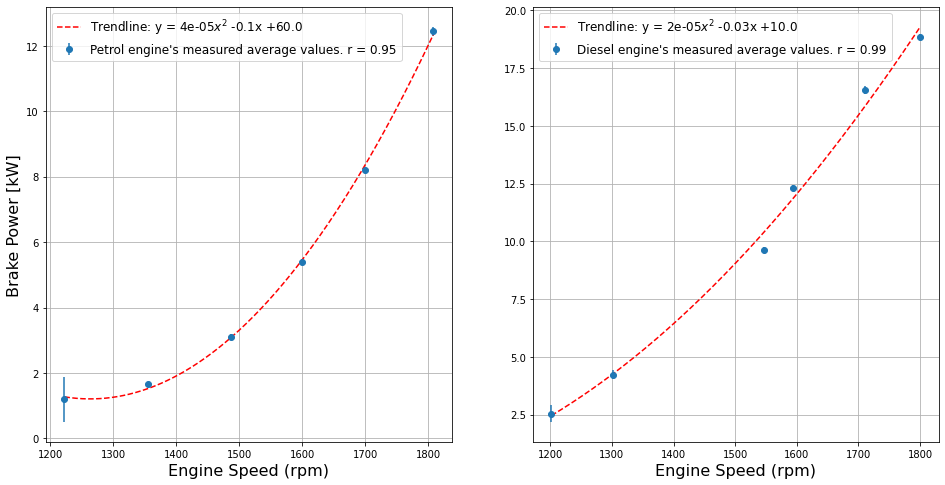

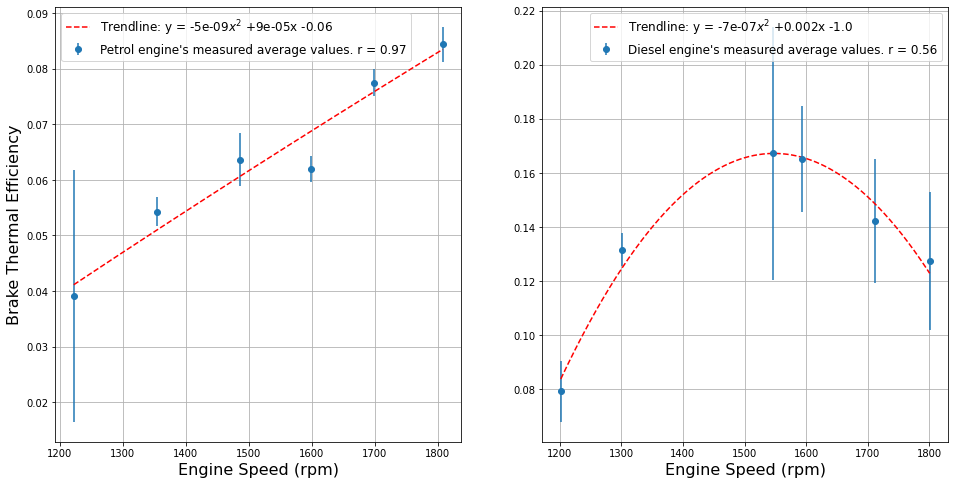

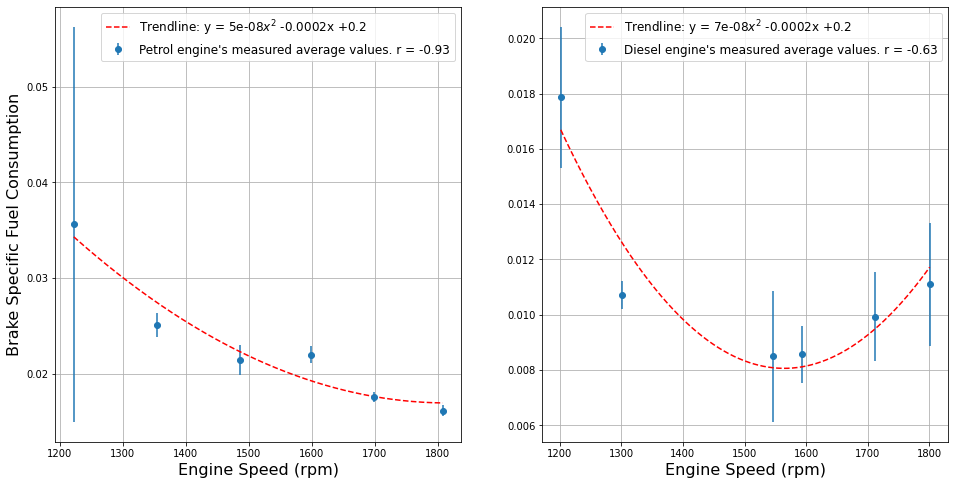

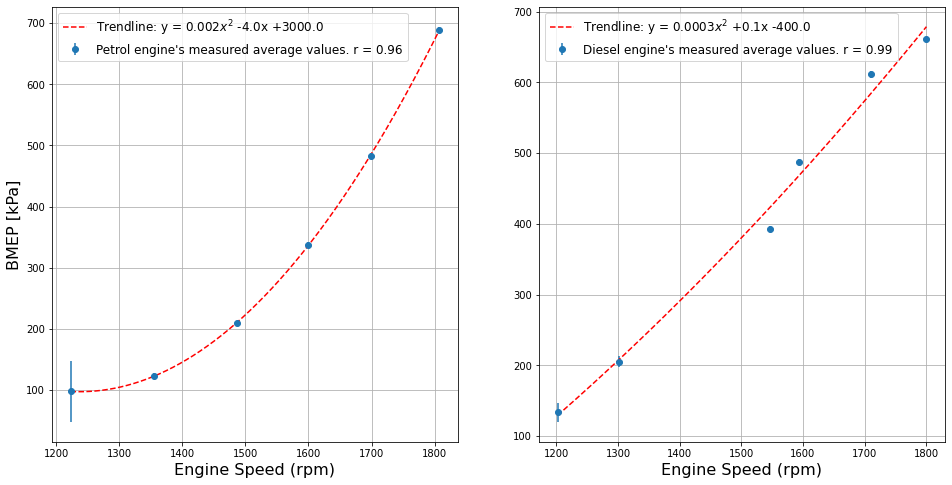

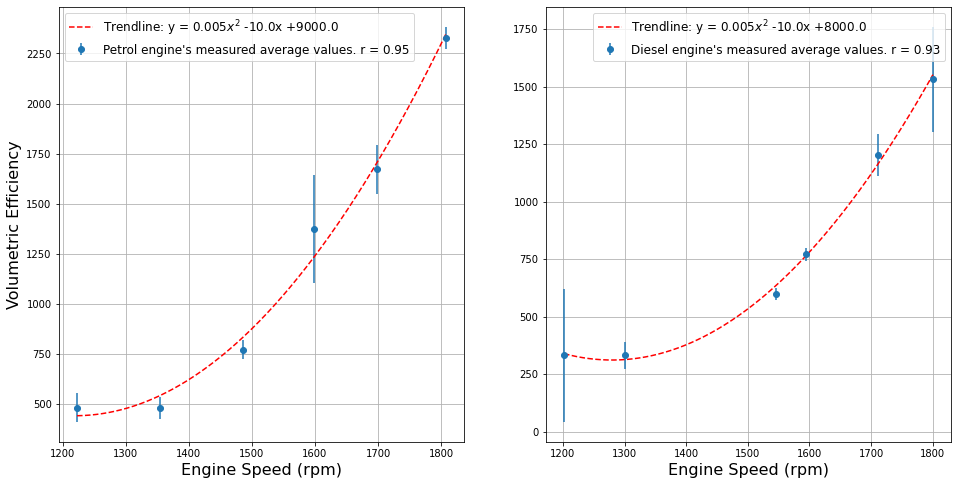

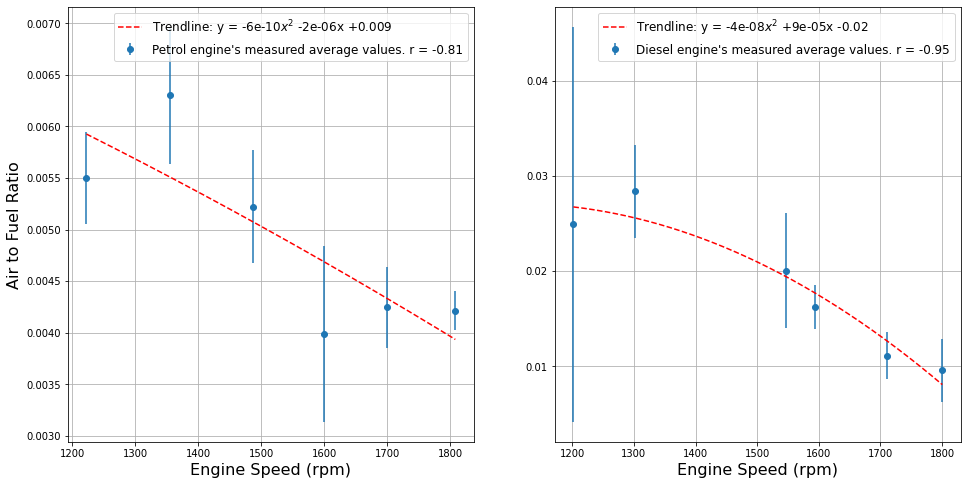

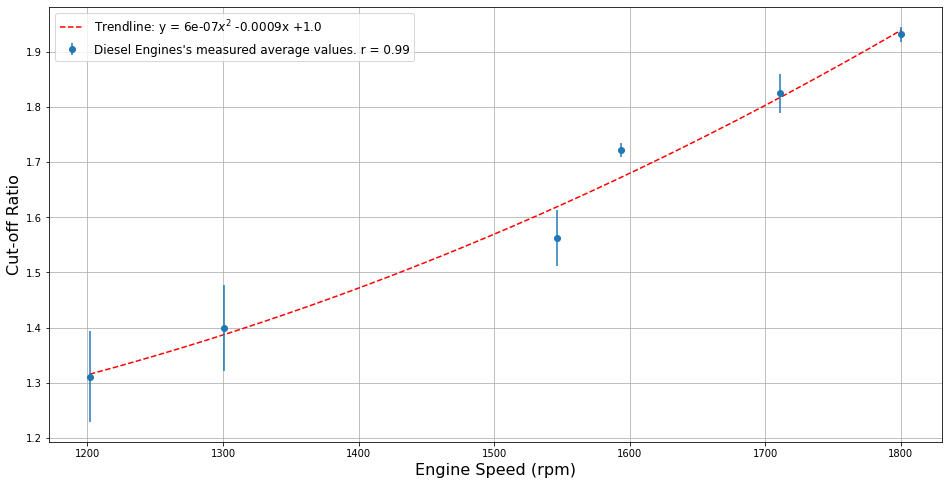

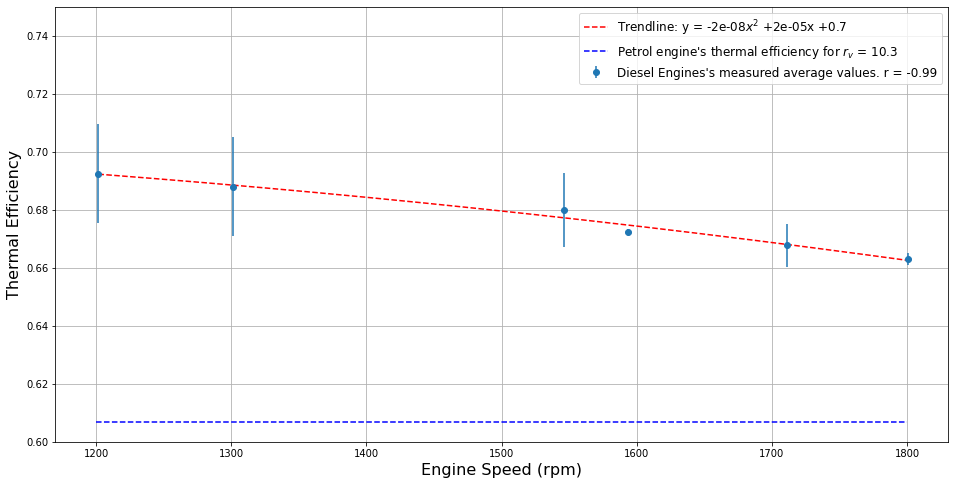

In [56]:
for key in quantity_error_dict:
    plot_individual_quantity(key)